# Comprobación de efectividad de ESRGAN sobre las imágenes

En este anexo, estudiaremos el impacto real de usar una GAN de super resolución haciendo uso de la partición de validación, comparando si se trata de una mejora significativa o NO. Para ello, tomaremos ASAN, el dataset reescalado mediante este mecanismo.

In [ ]:
# Librerías utilizadas por el script
import os
import cv2
import zipfile
import csv
import pathlib
import shutil

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from copy import deepcopy
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fasst.ai/t/plotting-metrics-after-learning/69937

import fastbook

fastbook.setup_book()
import fastai
import fastcore

print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *


@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None:
        nrows = int(np.ceil(n / ncols))
    elif ncols is None:
        ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

Importamos el modelo a utilizar, mobilenetv3.

In [ ]:
from fastai.vision.all import *
import timm

mobilenet3 = timm.create_model('mobilenetv3_large_100', pretrained=True)
mobilenet3.eval()

## Imágenes reescaladas
A continuación, estudiamos la efectivdad separando solo las fotos reescaladas.

In [ ]:
def label_func(fname):
    el = df.loc[df['image'] == str(fname).split("\\")[-1]]
    return ((el['class'].values[0]))

In [ ]:
# Obtenemos ASAN
# División en 80% train y 20% validación

df = pd.read_csv('trainSet.csv')

trainSet = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # La entrada es un bloque de imagenes, y la salida, categorias
    get_items=get_image_files,  # Utilizamos el mñetodo get_image_files proporcionado en el Notebook
    splitter=RandomSplitter(valid_pct=0.2, seed=0),  # Establecida semilla 0
    get_y=label_func,  # Las etiquetas son especificadas como contenido del dataset en si
    item_tfms=[Resize(224, method='squish')],  # Redimensionado
).dataloaders("ESRGAN/test/", bs=32)

In [ ]:
trainSet.show_batch()  # shows a batch of images

In [ ]:
mobilenet_learner = Learner(trainSet, mobilenet3, loss_func=FocalLoss(), metrics=[accuracy, error_rate])
mobilenet_learner.summary()

In [ ]:
lrs = mobilenet_learner.lr_find()

In [ ]:
# Entrena las capas superiores
mobilenet_learner.fine_tune(epochs=5, base_lr=lrs[0])


In [ ]:
mobilenet_learner.recorder.plot_metrics()  #Muestra las pérdidas, el accuracy y la tasa de error

In [ ]:
# Descongela todas las capas
mobilenet_learner.unfreeze()

# Encuentrar nuevo lr
lrs = mobilenet_learner.lr_find()

mobilenet_learner.fine_tune(epochs=10, base_lr=lrs[0])

In [ ]:
interp = ClassificationInterpretation.from_learner(mobilenet_learner, 1, trainSet.valid)

preds, targets = mobilenet_learner.get_preds(ds_idx=1)  # ds_idx=1 para el conjunto de validación

y_true = targets.numpy()
y_pred = preds.argmax(dim=1).numpy()  # Convierte las probabilidades en etiquetas predichas

In [23]:
balanced_acc = balanced_accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Balanced accuracy: {balanced_acc * 100:.4f}")
print(f"Precision: {prec * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")


Balanced accuracy: 69.3878
Precision: 73.7520
F1 Score: 73.5409


Ahora, podemos ver la tasa de aciertos y precisión por cada clase clasificada:

In [25]:
from sklearn.metrics import classification_report

y_true = targets.numpy()
y_pred = preds.argmax(dim=1).numpy()  # Convierte las probabilidades en etiquetas predichas

report = classification_report(y_true, y_pred,target_names=trainSet.vocab)
print(report)

                           precision    recall  f1-score   support

        actinic_keratosis       0.65      0.60      0.62        92
     basal_cell_carcinoma       0.73      0.72      0.72       130
           dermatofibroma       0.89      0.73      0.80       168
               hemangioma       0.83      0.85      0.84       292
intraepithelial_carcinoma       0.60      0.53      0.56       110
              lentigo_nos       0.79      0.75      0.77       138
                 melanoma       0.76      0.66      0.70        67
                    nevus       0.75      0.81      0.78       325
       pyogenic_granuloma       0.68      0.64      0.66        36
      seborreic_keratosis       0.62      0.61      0.61       166
  squamous_cell_carcinoma       0.64      0.63      0.63       145
                     wart       0.73      0.82      0.77       333

                 accuracy                           0.74      2002
                macro avg       0.72      0.69      0.71    

## Imágenes originales
Ahora, realizaremos el mismos experimento, pero sin ampliar las imágenes

In [86]:
def label_func(fname):
    el = df.loc[df['image'] == str(fname).split("\\")[-1]]
    return ((el['class'].values[0]))

In [84]:
"""# Ruta de la carpeta con los archivos
datos = pd.read_csv('trainSet.csv')


ruta_carpeta = r"ESRGAN\LR\wart_lr"

# Lee el DataFrame (ajusta la ruta según tu caso)

# Itera a través de los archivos en la carpeta
for archivo in os.listdir(ruta_carpeta):
    if archivo not in datos['image'].tolist():
        # Elimina el archivo si su nombre no está en el DataFrame
        os.remove(os.path.join(ruta_carpeta, archivo))
        print(f"Archivo eliminado: {archivo}")

print("Proceso completado.")"""

Archivo eliminado: ASAN_10000.png
Archivo eliminado: ASAN_10002.png
Archivo eliminado: ASAN_10003.png
Archivo eliminado: ASAN_10004.png
Archivo eliminado: ASAN_10007.png
Archivo eliminado: ASAN_10011.png
Archivo eliminado: ASAN_10012.png
Archivo eliminado: ASAN_10014.png
Archivo eliminado: ASAN_10015.png
Archivo eliminado: ASAN_10019.png
Archivo eliminado: ASAN_10026.png
Archivo eliminado: ASAN_10028.png
Archivo eliminado: ASAN_10032.png
Archivo eliminado: ASAN_10033.png
Archivo eliminado: ASAN_10035.png
Archivo eliminado: ASAN_10039.png
Archivo eliminado: ASAN_10046.png
Archivo eliminado: ASAN_10049.png
Archivo eliminado: ASAN_10050.png
Archivo eliminado: ASAN_10053.png
Archivo eliminado: ASAN_10059.png
Archivo eliminado: ASAN_10062.png
Archivo eliminado: ASAN_10065.png
Archivo eliminado: ASAN_10066.png
Archivo eliminado: ASAN_10068.png
Archivo eliminado: ASAN_10075.png
Archivo eliminado: ASAN_10077.png
Archivo eliminado: ASAN_10078.png
Archivo eliminado: ASAN_10079.png
Archivo elimin

In [87]:
# Obtenemos ASAN
# División en 80% train y 20% validación

df = pd.read_csv('trainSet.csv')

trainSet_lr = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # La entrada es un bloque de imagenes, y la salida, categorias
    get_items=get_image_files,  # Utilizamos el mñetodo get_image_files proporcionado en el Notebook
    splitter=RandomSplitter(valid_pct=0.2, seed=0),  # Establecida semilla 0
    get_y=label_func,  # Las etiquetas son especificadas como contenido del dataset en si
    item_tfms=[Resize(224, method='squish')],  # Redimensionado
).dataloaders("ESRGAN/LR/", bs=32)

In [90]:
mobilenet3 = timm.create_model('mobilenetv3_large_100', pretrained=True)
mobilenet_learner_lr = Learner(trainSet_lr, mobilenet3, loss_func=FocalLoss(), metrics=[accuracy, error_rate])
mobilenet_learner_lr.summary()

MobileNetV3 (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 16 x 112 x 112 
Conv2d                                    432        True      
Identity                                                       
Hardswish                                                      
Conv2d                                    144        True      
Identity                                                       
ReLU                                                           
Identity                                                       
Conv2d                                    256        True      
Identity                                                       
Identity                                                       
Identity                                                       
____________________________________________________________________________
                     32 x 64 x 112 x 112 
Conv2d                   

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.080337,0.800840,0.629870,0.370130,01:40


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.458483,0.694044,0.663337,0.336663,01:05
1,0.348350,0.613466,0.697802,0.302198,01:05
2,0.150148,0.592430,0.707792,0.292208,01:06
3,0.072389,0.591344,0.717283,0.282717,01:06
4,0.044515,0.587634,0.722278,0.277722,01:06


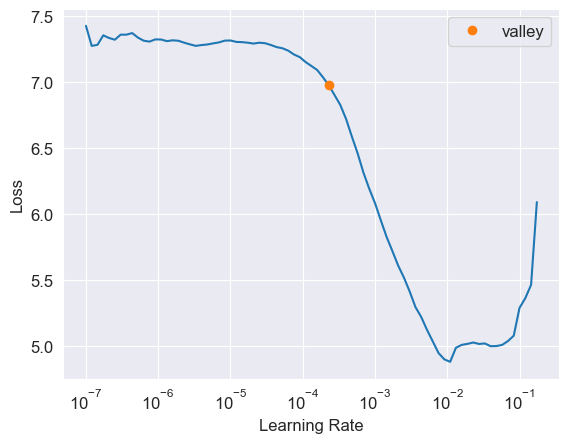

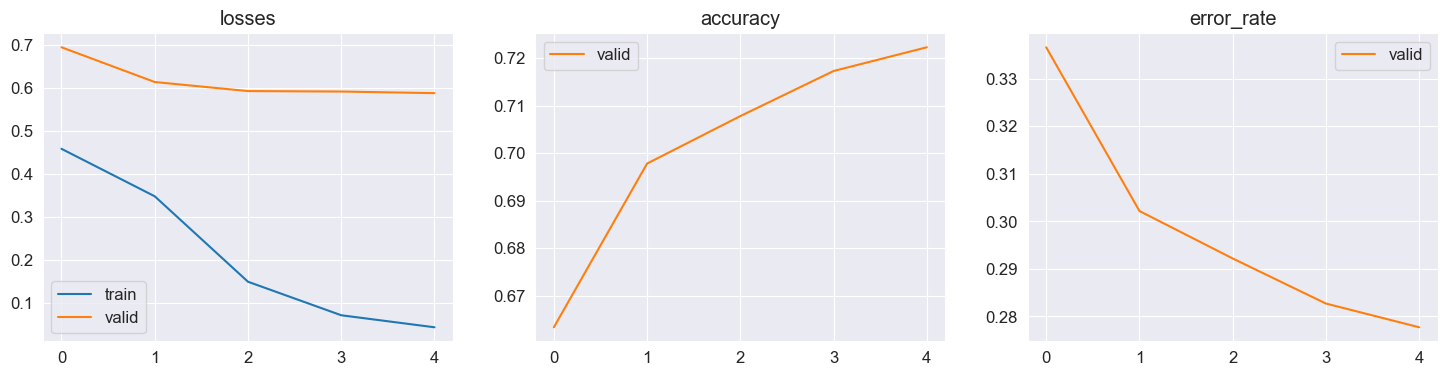

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.094072,0.710605,0.701299,0.298701,01:06


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.038564,0.618517,0.722777,0.277223,01:06
1,0.028198,0.626347,0.732767,0.267233,01:07
2,0.036368,0.666786,0.717283,0.282717,01:06
3,0.021930,0.665651,0.735265,0.264735,01:06
4,0.014507,0.657431,0.732268,0.267732,01:08
5,0.008012,0.641819,0.744256,0.255744,01:07
6,0.006162,0.659059,0.744755,0.255245,01:05
7,0.008364,0.650244,0.742258,0.257742,01:05
8,0.004644,0.649524,0.748751,0.251249,01:06
9,0.003171,0.653864,0.752248,0.247752,01:07


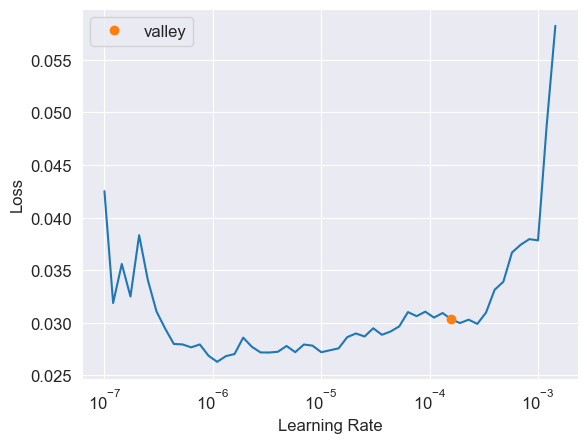

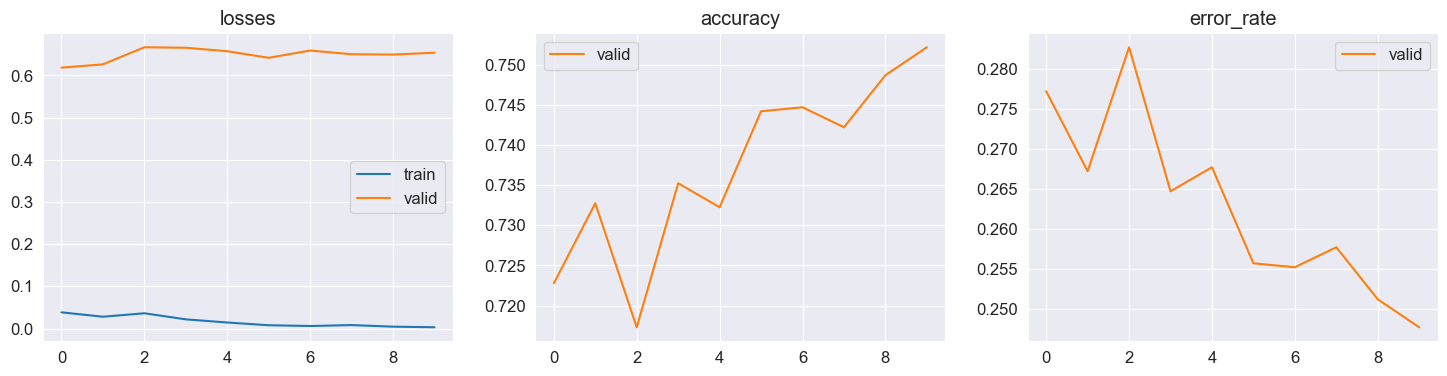

In [91]:
lrs = mobilenet_learner_lr.lr_find()
# Entrena las capas superiores
mobilenet_learner_lr.fine_tune(epochs=5, base_lr=lrs[0])

mobilenet_learner_lr.recorder.plot_metrics()  #Muestra las pérdidas, el accuracy y la tasa de error
# Descongela todas las capas
mobilenet_learner_lr.unfreeze()

# Encuentrar nuevo lr
lrs = mobilenet_learner_lr.lr_find()

mobilenet_learner_lr.fine_tune(epochs=10, base_lr=lrs[0])
mobilenet_learner_lr.recorder.plot_metrics()  #Muestra las pérdidas, el accuracy y la tasa de error

In [93]:
interp = ClassificationInterpretation.from_learner(mobilenet_learner_lr, 1, trainSet.valid)

preds, targets = mobilenet_learner_lr.get_preds(ds_idx=1)  # ds_idx=1 para el conjunto de validación

y_true = targets.numpy()
y_pred = preds.argmax(dim=1).numpy()  # Convierte las probabilidades en etiquetas predichas
balanced_acc = balanced_accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Balanced accuracy: {balanced_acc * 100:.4f}")
print(f"Precision: {prec * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")

from sklearn.metrics import classification_report

y_true = targets.numpy()
y_pred = preds.argmax(dim=1).numpy()  # Convierte las probabilidades en etiquetas predichas

report = classification_report(y_true, y_pred, target_names=trainSet_lr.vocab)
print(report)

Balanced accuracy: 69.9857
Precision: 75.1969
F1 Score: 74.9611
                           precision    recall  f1-score   support

        actinic_keratosis       0.52      0.65      0.58        72
     basal_cell_carcinoma       0.77      0.69      0.73       131
           dermatofibroma       0.83      0.80      0.82       137
               hemangioma       0.88      0.85      0.86       307
intraepithelial_carcinoma       0.59      0.40      0.48       108
              lentigo_nos       0.80      0.80      0.80       142
                 melanoma       0.77      0.65      0.70        88
                    nevus       0.79      0.86      0.82       323
       pyogenic_granuloma       0.69      0.56      0.62        43
      seborreic_keratosis       0.63      0.60      0.62       166
  squamous_cell_carcinoma       0.67      0.71      0.69       153
                     wart       0.75      0.83      0.79       332

                 accuracy                           0.75      2